# Week 6: Introduction to ensembles

----------------------------------------------------
Machine Learning                      

Year 2020/2021

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* 

----------------------------------------------------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#1. Introduction to ensembles

The goal of ensemble learning is to combine a set of base learners to build an improved prediction model. The key idea  behind ensembles lies in exploiting the diversity among the base learners; the way of generating this diversity let us classify these methods into two main types:

* **Bagging**: the diversity  among classifiers is generated using different partitions of the training data.
* **Boosting**: it sequentially train a set of weak classifiers using modified versions of the data.

We have already seen a kind of these methods: *Random Forests (RF)*. Remember that RF train a set of trees, each tree use a different subset of samples and features, and later combine their outputs. So, we can say that RF is a Bagging method. 


**NOTE**: here, we are going to review these methods (and their implementations) for the binary clasification case, but we can find similar approaches for regression and multiclass problems.


# 2. Bagging: Boostrap Aggregating

A bagging ensemble combines a set of classiffiers where each base learner is trained with a bagged subset of the training samples. This bagging subsampling consists in randomly, and with replacement,  choosing multiple random samples from the original training data. 

Once the set of base learners is trained, the final ensemble output is obtained by averaging all learner's outputs. In the classification case, usually a majority vote is applied.

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/Bagging.png" width="48%" > 

Bagging models can be trained in sklearn using the class [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) which allows you to define a base learner/estimator along with different parameters adjust the strategy to draw random subsets. Additionaly, sklearn also includes two specific methods for bagged ensembles of decision trees:
* **[Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)** which combines a set of trees by sumbsamplig both data and features. 

* **[Extremely Randomized Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)**. This ensemble works as a RF, but instead of looking for the most discriminative thresholds, it forces additional diversity by using random thresholds for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.


(*) Figure from https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de


**References**

L. Breiman, “Bagging predictors”, Machine Learning, 24(2), 123-140, 1996.


### Create a bagged ensemble

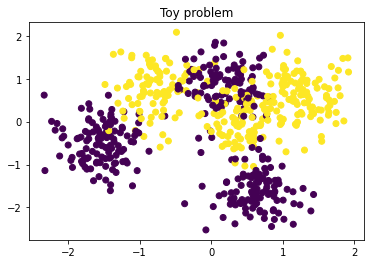

In [2]:
# Generate a toy problem 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_blobs
n_samples = 1000
random_state = 170
X, y = make_blobs(n_samples=n_samples, centers=6,cluster_std = 2, random_state=random_state)
# Convert to binary
y[y==2]=0
y[y==3]=0
y[y==4]=1
y[y==5]=1

# Create data partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.4)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
plt.title("Toy problem")
plt.show()

### Step 1: Subsampling
Let's train several decision trees with subsampled versions of the training data. 

In [3]:
# Some utility functions

def plot_boundary(clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

Accuracy tree 0: 0.75
Accuracy tree 1: 0.89
Accuracy tree 2: 0.74
Accuracy tree 3: 0.84
Accuracy tree 4: 0.81
Accuracy tree 5: 0.77
Accuracy tree 6: 0.75
Accuracy tree 7: 0.86
Accuracy tree 8: 0.78
Accuracy tree 9: 0.76


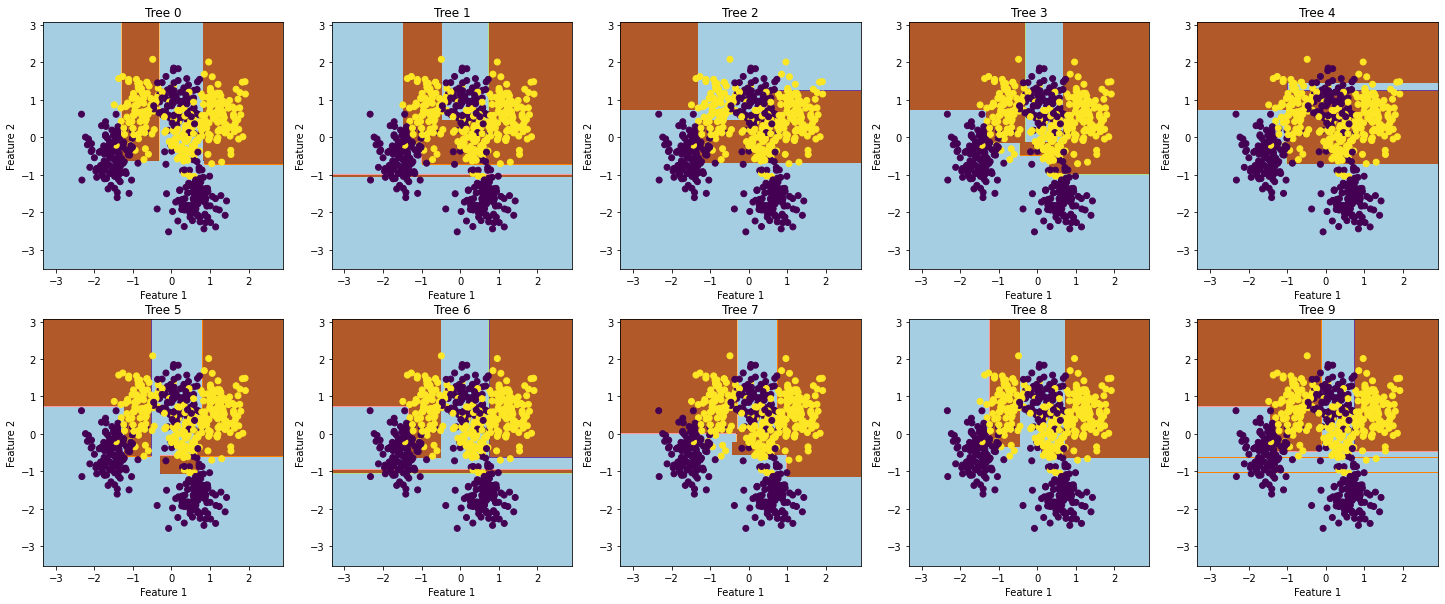

In [4]:
from sklearn import tree
import copy

# Some parameters
max_depth = 4
T =10
nperc = 0.4
N = X_train.shape[0]
Ntest = X_test.shape[0]
Nsub = np.int(nperc*N)

# Define the base classifier
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
ensemble_clf = []
o_train = np.zeros((T,N))
o_test = np.zeros((T,Ntest))
 
plt.figure(figsize=(25,10))
np.random.seed(0)

# Repeat this T times....
for t in range(T):
  # Subsampling with replacement
  samples_bag = np.random.choice(N, Nsub, replace=True)
  X_train_sub  = X_train[samples_bag,:]
  Y_train_sub  = Y_train[samples_bag]

  # Train a bagged tree
  clf_tree.fit(X_train_sub, Y_train_sub)
  ensemble_clf.append(copy.copy(clf_tree))
  
  # Get and save soft-output
  o_train[t,:] = clf_tree.predict_proba(X_train)[:,1]
  o_test[t,:] = clf_tree.predict_proba(X_test)[:,1]

  # Compute test predictions
  acc = clf_tree.score(X_test, Y_test)
  print('Accuracy tree %d: %2.2f'%(t, acc))
  
  # Plot the solution
  plt.subplot(2,5,t+1)
  plot_boundary(clf_tree, X_train, Y_train, plt)
  plt.title('Tree '+str(t))

plt.show()

### Step 2: Combining the outputs

In classification problems we can find two approaches to obtain the final output of the ensemble:

1. **Calculating the mode of the outputs of the base classifiers**.
When we work with classification problems, it is quite common to obtain the ensemble output as the most frequent output. With this scheme, the output of each base classifier is considered to be a vote and the final ensemble output is calculated as the majority vote.


2. **Calculating the average of the outputs of the base classifiers**.
Another option is to leverage the outputs of the classifiers to compute the final prediction as an average of all the predictions of the base classifiers. This option is also used in classification problems, but this is the typical approach for regression problems.




In [5]:
# Solution computing the ensemble output with the mode
from scipy import stats
from sklearn.metrics import accuracy_score
# Use the values saved in o_train and o_test

# Convert soft-output to target values
o_train_pred = np.where(o_train > 0.5, 1, 0)
o_test_pred = np.where(o_test > 0.5, 1, 0)

# Compute the mode
f_train_pred = np.squeeze(stats.mode(o_train_pred, axis=0)[0])
f_test_pred = np.squeeze(stats.mode(o_test_pred, axis=0)[0])

# Final ensemble performance
acc_ens = accuracy_score(f_test_pred, Y_test)
print('Ensemble accuracy: %2.2f'%(acc_ens))

Ensemble accuracy: 0.80


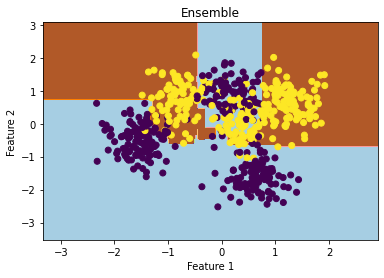

In [6]:
def plot_boundary(ensemble_clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
    Z = np.zeros((len(ensemble_clf), xx.ravel().shape[0]))
    for t, clf in enumerate(ensemble_clf):
      Z[t,:] = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      
    Z_ens_pred = np.squeeze(stats.mode(Z, axis=0)[0])

    Z_ens_pred = Z_ens_pred.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z_ens_pred, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    #for i, color in zip(range(n_classes), plot_colors):
    #    idx = np.where(Y == i)
    #    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

plt.figure()
plot_boundary(ensemble_clf, X_train, Y_train, plt)
plt.title('Ensemble')
plt.show()

In [7]:
# Solution computing the ensemble output with the mean
# Use the values saved in o_train and o_test

# Convert soft-output to target values
o_train_pred = np.where(o_train > 0.5, 1, 0)
o_test_pred = np.where(o_test > 0.5, 1, 0)

# Compute the mode
f_train_pred = np.where(np.mean(o_train, axis=0) > 0.5, 1, 0)
f_test_pred = np.where(np.mean(o_test, axis=0) > 0.5, 1, 0)

# Final ensemble performance
acc_ens = accuracy_score(f_test_pred, Y_test)
print('Ensemble accuracy: %2.2f'%(acc_ens))

Ensemble accuracy: 0.87


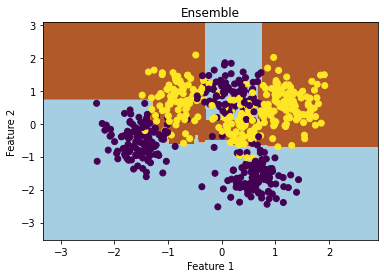

In [8]:
def plot_boundary(ensemble_clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
    Z = np.zeros((len(ensemble_clf), xx.ravel().shape[0]))
    for t, clf in enumerate(ensemble_clf):
      Z[t,:] = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    Z_ens_pred = np.where(np.mean(Z, axis=0) > 0.5, 1, 0)
    Z_ens_pred = Z_ens_pred.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z_ens_pred, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    #for i, color in zip(range(n_classes), plot_colors):
    #    idx = np.where(Y == i)
    #    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

plt.figure()
plot_boundary(ensemble_clf, X_train, Y_train, plt)
plt.title('Ensemble')
plt.show()



# 3. Boosting: Real Adaboost

Boosting methods train a sequence of weak classifiers with weighted or emphasized versions of the training data. Each one of these classifiers is weak since its error rate can be only slightly better than random guessing. Finally, to obtain the final ensemble output, the predictions from all of them are then combined through a weighted combination of all learners' outputs.


The most popular boosting algorithm is called **AdaBoost** (Adaptive Boosting). This boosting method trains this sequence of weak classifiers in such way that each new classifier pay more attention to samples missclassified by the previous learners. Versions of this algorithm are:
* AdaBoost.M1 or  “Discrete AdaBoost” where base learners outputs are discrete estimations of the output class.
* “Real AdaBoost”, in this case, the base classifier returns a real-valued prediction (e.g., a probability mapped to the interval [−1,1]).

Let's now go deeper in the working principles of the **Real AdaBoost** algorithm.



## Real Adaboost
Consider we have a binary classification problem given by training dataset $S$ consisting  of $N$ pairs $(\mathbf{x}^{(i)},y^{(i)})$, where $\mathbf{x}^{(i)}\in\mathbb{R}^L$ is the $i$-th observation and $y^{(i)}\in\{-1,1\}$  is its associated label.

Real Adaboost (RA) sequentially trains a set of $T$ learners where each learner implements a prediction function $o_t(x) \in [-1,1]$. To learn this prediction function each learner observes the overall training dataset $S$, but an emphasis function $D_t(\mathbf{x})$ is used during its training to make the learner pay more attention to most erroneous samples.
Finally, the ensemble output is obtained as a weighted sum of all learners' outputs:

$$ f_T({\bf x}) = \displaystyle \sum_{t=1}^T \alpha_t o_t({\bf x})$$

<center>  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/boosting.jpg" width="30%" > </center>



* **Emphasis function**:
To force diversity among the base learners, by means of an emphasis function, RA weighs the training observations. Initially all weights are equal:
$$ D_{1}({\bf x}^{(i)}) = \frac{1}{N}   $$

  so that the first learner is trained in the usual manner. For next iterations,  $t = 2,3,\ldots,T$, the emphasis function is updated with the following rule:
$$ D_{t+1}({\bf x}^{(i)}) = \frac{D_{t}({\bf x}^{(i)}) \exp \left( - \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right)}{Z_t}   $$
  where $Z_t$ is a normalization constant making $\sum_{i=1}^N D_{t+1}({\bf x}^{(i)})  = 1$. Note that this update rule increases the emphasis weight for those observations that were misclassified by the previous classifiers, whereas the weights are decreased for those that were  correctly classified. Thus, as new learners are added to the ensemble, most erroneous samples will receive an increased attention.

* **Output weights ($\alpha_t$)**
To obtain the output weights, RA minimizes the exponential loss function:
$${\bf \alpha}^* =\displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t=1}^T \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right) = \displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - f_T({\bf x}^{(i)}) {y}^{(i)} \right)$$
which solution can be analytically computed as
$$\alpha_t = \frac{1}{2} \ln \left( \frac{1+\gamma_t}{1-\gamma_t}\right)$$
where $\gamma_t = \sum_{i=1}^N   D_{t}({\bf x}^{(i)}) o_t({\bf x}^{(i)}) {y}^{(i)} $. The effect of these weights is to give higher influence to the more accurate classifiers in the ensemble. 


**Función de coste exponencial**
Esta función de coste es bastante similar a la utilizada por los modelos de regresión logística y es una cota superior del error de clasificación.



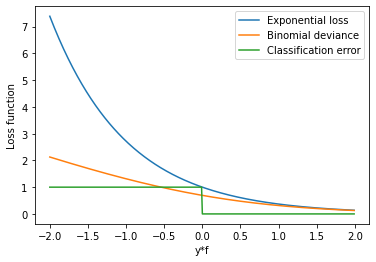

In [9]:
# Plot the exponential loss function (un upper bound of the classfication error)
f = np.arange(-2,2,0.01)
y = 1

l_alpha = np.exp(-y*f)
plt.figure()
plt.plot(y*f,l_alpha, label='Exponential loss')


# Compare with binomial deviance
l_w = np.log(1+ np.exp(f))-y*f
plt.plot(y*f,l_w, label='Binomial deviance')

# Classification error
e_class = np.zeros(f.shape)
e_class[y*f<0] =1
plt.plot(y*f,e_class, label='Classification error')

plt.legend()
plt.xlabel('y*f')
plt.ylabel('Loss function')

plt.show()

## Let's create our Boosting ensemble (Real Adaboost)

### Step 1: Train the first classifier

In [10]:
from sklearn import tree
import copy

N = X_train.shape[0]
max_depth =4
clf_ens =[]
alpha_ens = []
f_pred_train = np.zeros((N,))
# Initialize emphasis function
Dt = (1./N) * np.ones((N,))
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth) 

# Train a boosted tree (use sample_weight parameter)
clf_tree.fit(X_train, Y_train, sample_weight=Dt)
clf_ens.append(copy.copy(clf_tree))
# Compute tree soft-outputs (interval [-1,1])
o_t = 2*clf_tree.predict_proba(X_train)[:,1]-1
  
# Compute output weights
gamma_t = Dt @ (o_t*(2*Y_train-1))
alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
alpha_ens.append(alpha_t)
# Update ensemble  output
f_pred_train = f_pred_train + alpha_t * o_t


Let's look at the output of this classifier and the most erroneous samples.

In [11]:
def plot_boundary(clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

In [12]:
def plot_boundaryRA(clf_ens, alpha_ens, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot                                             
   
    """

    plot_colors = "brymc"
    plot_step = 0.02
    X=X_train
    Y=Y_train
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = np.zeros((xx.ravel().shape))
    f_t = np.zeros((Y.shape))
    for t, clf in enumerate(clf_ens):
      Z_t = 2*clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]-1
      Z = Z + alpha_ens[t]*Z_t
      o_t = 2*clf.predict_proba(X)[:,1]-1
      f_t = f_t + alpha_ens[t]* o_t
    Z = np.where(Z > 0, 1, 0)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Mark erroneous samples
    # Compute output weights
    error_t =  f_t*(2*Y-1)
    pos_error = np.where(error_t<=0)[0]


    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, label='Training data')
    size=20*np.abs(error_t[pos_error])
    # Plot erroneous data
    plt.scatter(X[pos_error, 0], X[pos_error, 1], c='r', s = size, marker='x', label='Erroneous sample')
    plt.axis("tight")
    plt.legend()

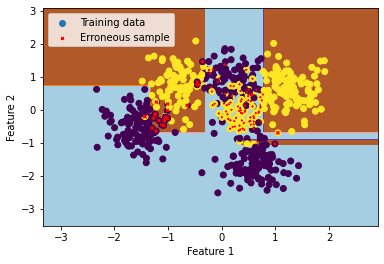

In [13]:
plt.figure()
plot_boundaryRA(clf_ens, alpha_ens, X_train, Y_train, plt)
plt.show()

### Step 2: Update the emphasis function and add another tree

In [14]:
# Update emphasis function
Dt = Dt * np.exp(-alpha_t * (o_t*Y_train))
Dt = Dt /np.sum(Dt)
# Train a boosted tree (use sample_weight parameter)
clf_tree.fit(X_train, Y_train, sample_weight=Dt)
clf_ens.append(copy.copy(clf_tree))
# Compute tree soft-outputs (interval [-1,1])
o_t = 2*clf_tree.predict_proba(X_train)[:,1]-1
  
# Compute output weights
gamma_t = Dt @ (o_t*(2*Y_train-1))
alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
alpha_ens.append(alpha_t)
# Update ensemble  output
f_pred_train = f_pred_train + alpha_t * o_t

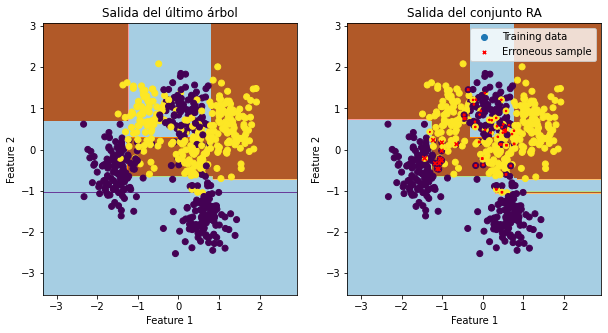

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_boundary(clf_ens[-1], X_train, Y_train, plt)
plt.title('Output of last tree')

plt.subplot(1,2,2)
plot_boundaryRA(clf_ens, alpha_ens, X_train, Y_train, plt)
plt.title('Output of RA ensemble')
plt.show()


### Step T: We repeat this process T times...

<Figure size 1440x1800 with 0 Axes>

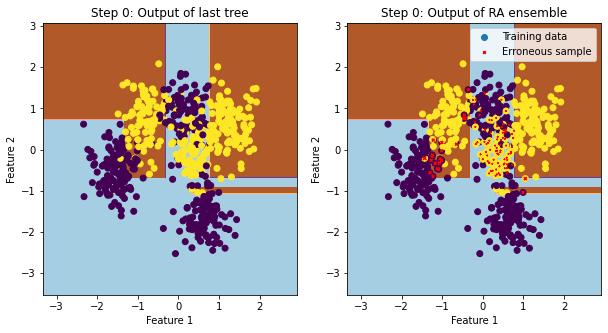

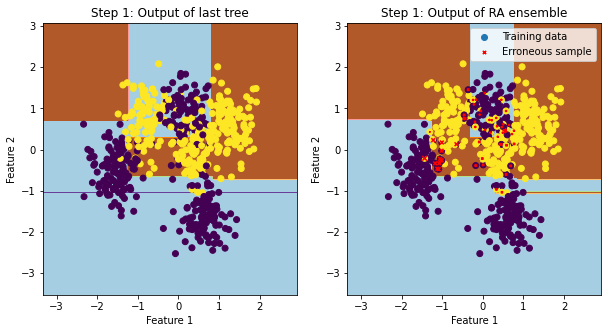

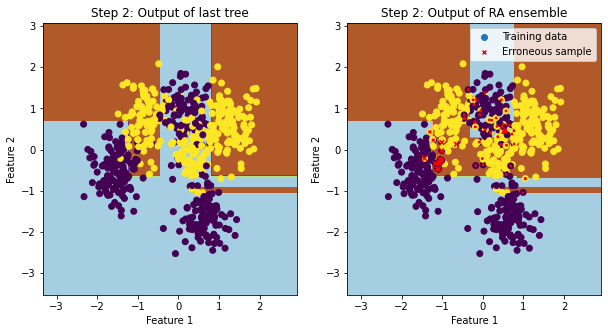

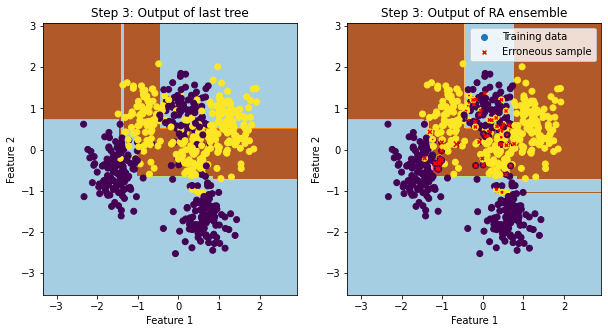

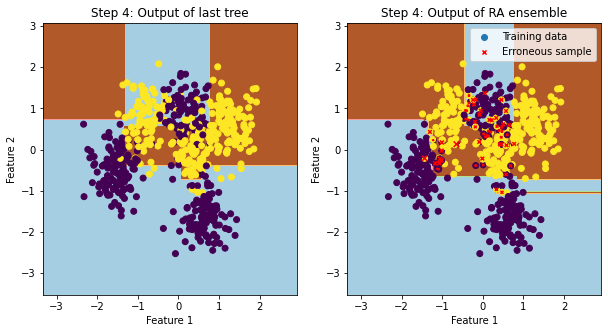

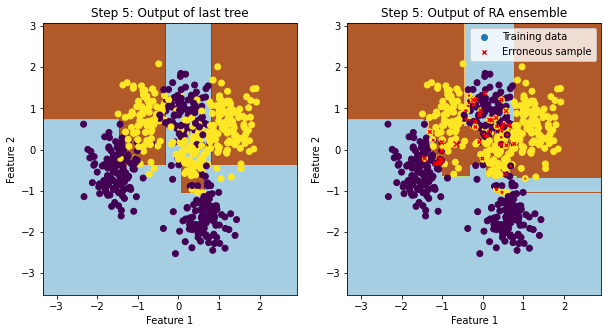

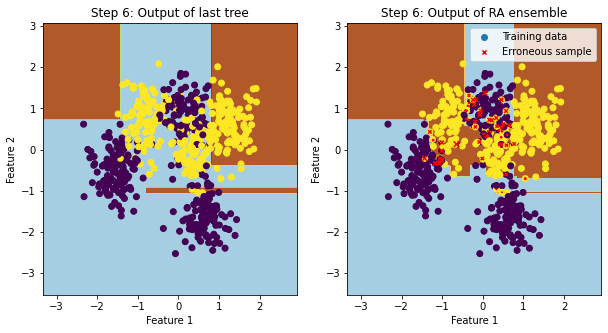

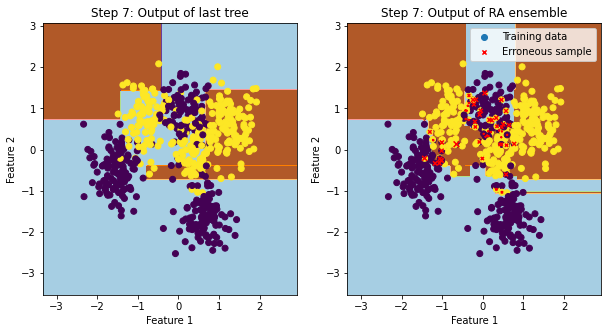

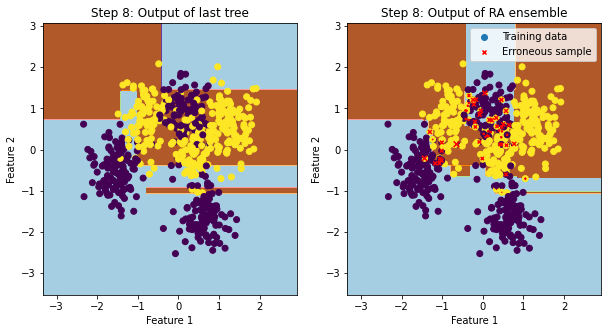

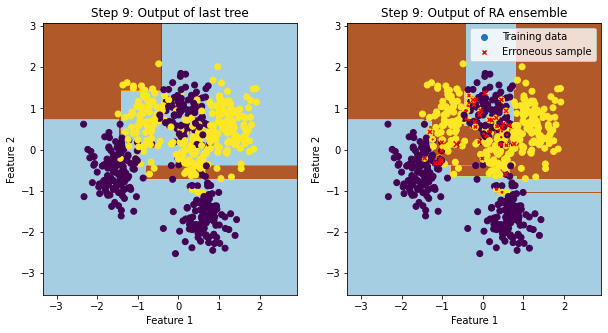

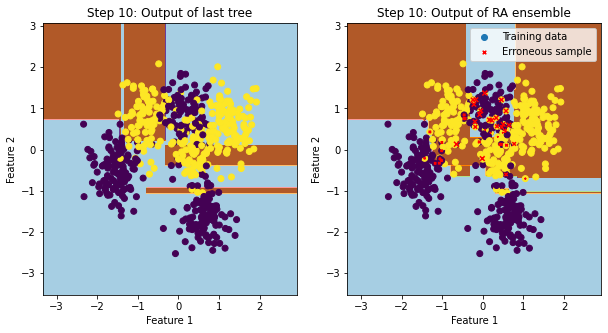

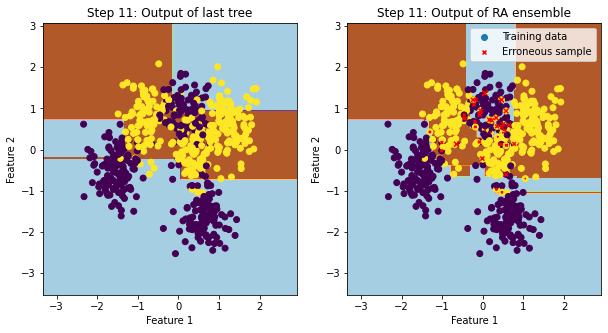

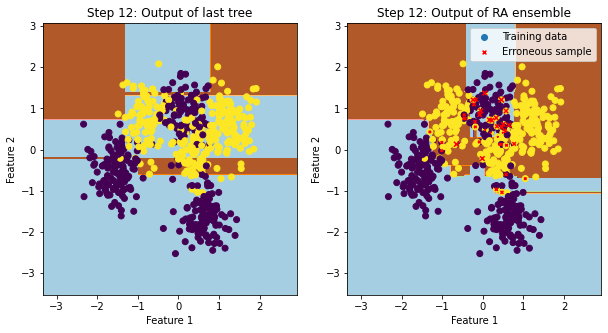

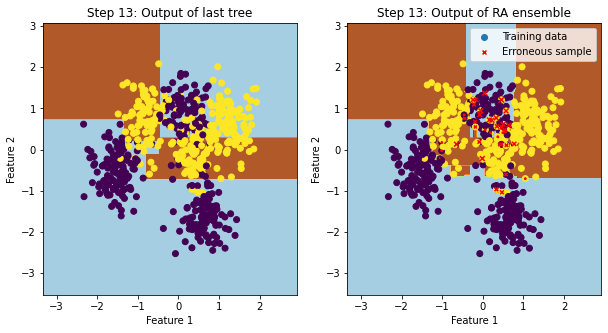

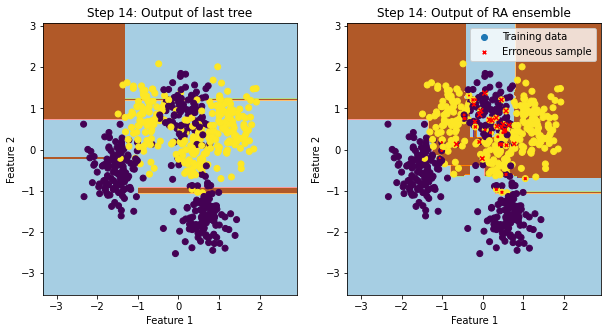

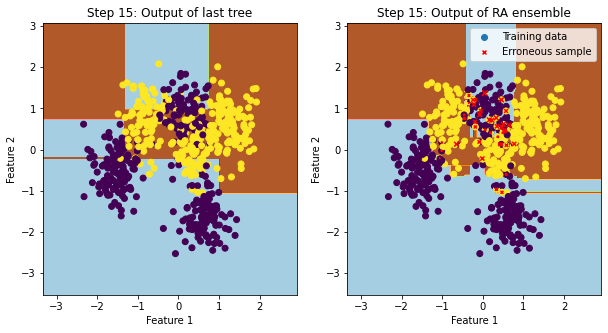

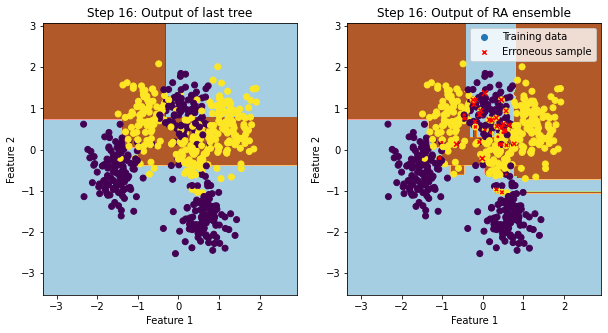

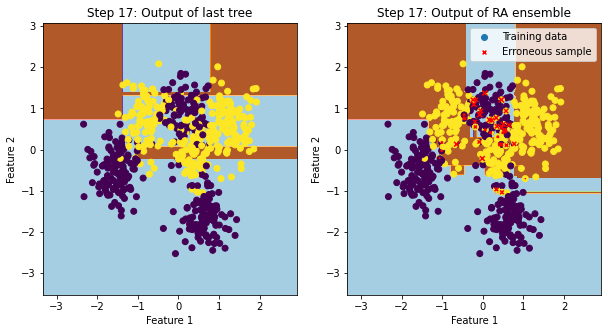

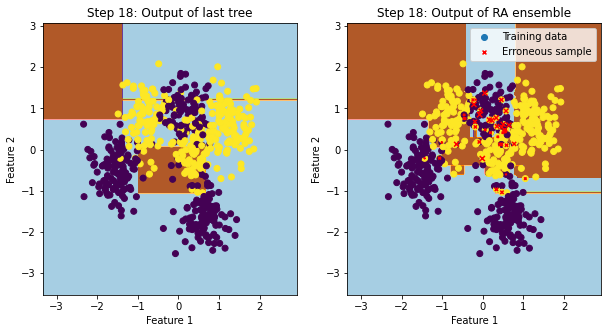

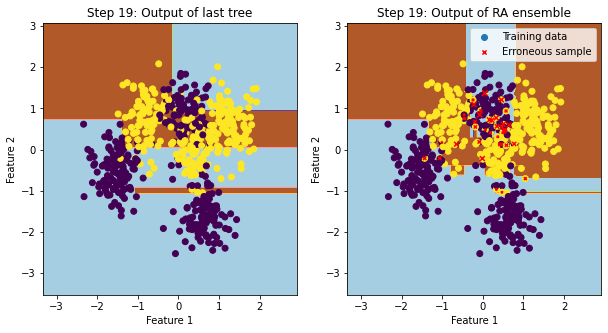

In [20]:
from sklearn import tree
N = X_train.shape[0]
max_depth =4
clf_ens =[]
alpha_ens = []
f_pred_train = np.zeros((N,))
# Initialize emphasis function
Dt = (1./N) * np.ones((N,))
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth) 

T = 20
plt.figure(figsize=(20,25))
for t in range(T):
  # Train a boosted tree (use sample_weight parameter)
  clf_tree.fit(X_train, Y_train, sample_weight=Dt)
  clf_ens.append(copy.copy(clf_tree))
  # Compute tree soft-outputs (interval [-1,1])
  o_t = 2*clf_tree.predict_proba(X_train)[:,1]-1
    
  # Compute output weights
  gamma_t = Dt @ (o_t*(2*Y_train-1))
  alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
  alpha_ens.append(alpha_t)
  # Update ensemble  output
  f_pred_train = f_pred_train + alpha_t * o_t
  # Update emphasis function
  Dt = Dt * np.exp(-alpha_t * (o_t*Y_train))
  Dt = Dt /np.sum(Dt)
  # Plot the solution
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plot_boundary(clf_ens[-1], X_train, Y_train, plt)
  plt.title('Step '+str(t)+': Output of last tree')
  plt.subplot(1,2,2)
  plot_boundaryRA(clf_ens, alpha_ens, X_train, Y_train, plt)
  plt.title ('Step '+str(t)+': Output of RA ensemble')
  plt.show()


## Boosting as a gradient descent algorithm

The Real AdaBoost algorithm can be reformulated as a feature construction (*feature engineering*) algorithm in which each classifier provides a new feature to the ensemble and these are combined with some weights $\alpha_t$ to minimize the exponential cost function that minimizes RA.

Thus we can consider that RA trains a sequence of classifiers to build some features $o_t(\mathbf x)$, $t=1, \ldots, T$, so that the final output of the classifier or ensemble are given by a linear combination of the same ones

$$ f_T({\bf x}) = \displaystyle \sum_{t=1}^T \alpha_t o_t({\bf x})$$

and the weights of this combination are calculated so that the following cost function is minimized:
$${\bf \alpha}^* =\displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t=1}^T \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right) = \displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - f_T({\bf x}^{(i)}) {y}^{(i)} \right)$$

In addition, for the design of these features, at each iteration of the set, RA adds a new variable $o_t(\mathbf x)$ so as to achieve the largest possible reduction of the cost function up to step $t$, i.e.,

$$ \underset{{o_t(\mathbf x)}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t'=1}^t \alpha_{t'} o_{t'}({\bf x}^{(i)}) {y}^{(i)} \right) = \underset{{o_t(\mathbf x)}}{\operatorname{max}} \sum_{i=1}^N   D_{t}({\bf x}^{(i)}) o_t({\bf x}^{(i)}) {y}^{(i)} $$

That is, finding at each step the $o_t(\mathbf x)$ that provides the largest cost reduction is equivalent to maximizing an emphasized version of the classifier accuracy!!!!

Since adding at each step a new classifier or *feature* that minimizes the cost function is equivalent to moving in the direction of its gradient, this reformulation or reinterpretation of RA falls into the **Gradient Boosting** family of models. The advantage of this view of the problem is that we can choose different cost functions to obtain different Boosting models. In fact, the regression versions are formulated considering this formulation of the problem for the mean square error.





## Boosting implementations

We can find an implementation of the Real AdaBoost classifier in the sklearn library. This class, called [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier), allows us to use  Discrete and Real Adaboost versions by adjusting the parameter `algorithm` to `SAMME` or `SAMME.R`, respectivelly.

Additionaly, sklearn also includes an implementation of this family of models when the base classifiers are trees and are inside the [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) model. In addition, this class allows us to choose between two cost functions for the ensemble design: (1) the exponential function of the standard AR and (2) the binomial function used by logistic regression models.

For the implementation of Gradient Boosting methods it is quite common to use the [XGBoost library](https://xgboost.readthedocs.io/en/latest/index.html), since it provides an efficient implementation with parallelization capabilities (in case we need to work with large datasets). Besides, it has a [sklearn interface](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) which easily allows us integrate it with our common code.


**References**

* Schapire, R.E. "The strength of weak learnability". Machine Learning, 5(2): 1651-1686, 1990.

* Freund, Y. and Schapire, R.E. "Experiments with a new boosting algorithm". Proc. of the 13th International Conference on Machine Learning. pp. 148-156, 1996.

* Friedmann, J. H.,  “Stochastic Gradient Boosting”, 2007.


# 4. *Stacking* of classifiers

Stacking is another approach for the ensemble design, in which an ensemble is obtained directly from the combination of the predictions of several different classifiers such as a K-NN, LR, Trees, ..... The idea is that if these models provide different outputs (diversity) simply because they are different models, by combining their outputs we can reduce the final error variance.

There are schemes that use this idea by making different grouping layers where the classifiers are grouped at different levels. The simplest, and usual, scheme with a single aggregation layer is shown in the following figure(*):



<img align="center" src="https://miro.medium.com/max/1400/1*5O5_Men2op_sZsK6TTjD9g.png" width=50%>

If we want to directly implement this model and employ CV schemes using tools such as GridSearch it is not easy to define the pipeline.  However, the [ML-Ensemble] library (https://mlens.readthedocs.io/en/0.1.x/) is fully compatible with sklearn and simplifies this process.

(*) Figure from https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840


In [17]:
!pip install mlens

     |████████████████████████████████| 227 kB 6.5 MB/s 


In [18]:
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define ensemble model
ensemble = SuperLearner()

# Define set of classifiers of the input layer and add them to the ensemble
learners = [KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=10),KNeighborsClassifier(n_neighbors=20)]
ensemble.add(learners)

# Define output layer
ensemble.add_meta(LogisticRegression())

# Train and test the model
ensemble.fit(X_train, Y_train)
Y_pred = ensemble.predict(X_test)
acc_ens = accuracy_score(Y_test,Y_pred)

print('Stacked ensemble accuracy: %2.2f'%(acc_ens))

[MLENS] backend: threading


Stacked ensemble accuracy: 0.89


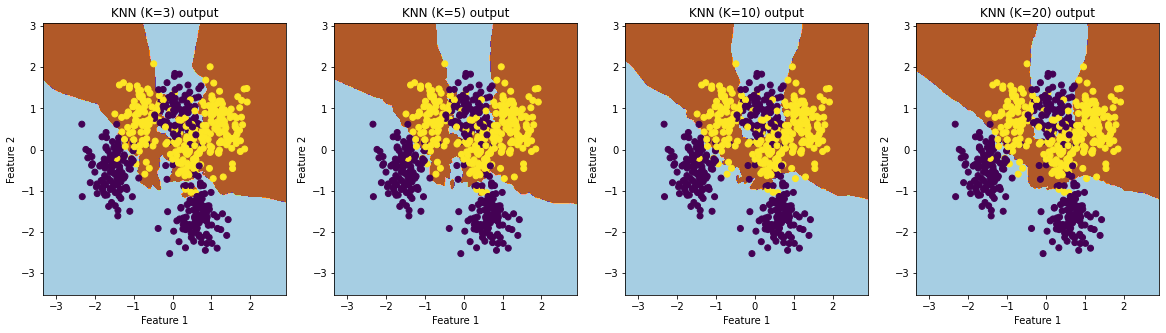

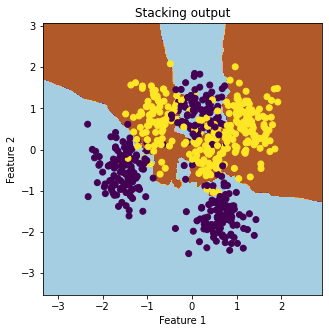

In [29]:
# Plot the solution
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plot_boundary(KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train), X_train, Y_train, plt)
plt.title('KNN (K=3) output')
plt.subplot(1,4,2)
plot_boundary(KNeighborsClassifier(n_neighbors=5).fit(X_train, Y_train), X_train, Y_train, plt)
plt.title('KNN (K=5) output')
plt.subplot(1,4,3)
plot_boundary(KNeighborsClassifier(n_neighbors=10).fit(X_train, Y_train), X_train, Y_train, plt)
plt.title('KNN (K=10) output')
plt.subplot(1,4,4)
plot_boundary(KNeighborsClassifier(n_neighbors=20).fit(X_train, Y_train), X_train, Y_train, plt)
plt.title('KNN (K=20) output')

plt.figure(figsize=(5,5))
plot_boundary(ensemble, X_train, Y_train, plt)
plt.title('Stacking output')
plt.show()

